In [1]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm
from langchain_openai import AzureOpenAIEmbeddings
import langchain
import json
import numpy as np
import torch
import time
import random
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger('httpx').setLevel(logging.WARNING)
logging.getLogger('httpcore').setLevel(logging.WARNING)

Let's fetch the dataframes.

In [2]:
from data_extractor import Extractor
extractor_instance = Extractor()
extractor_instance.extract(location="./data/results/df_combined.csv")

df_combined = pd.read_csv("data/results/df_combined.csv")
df_combined.sample(n=3)

Comp domain df length: 4172  - VTT domain df length: 4927
Example of text to compare: FiR 1 - FiR 1 is a Triga-type nuclear research reactor located in Otaniemi, Espoo, Finland, decommissioned by VTT after serving since 1962, used for nuclear research, training, and medical radiation therapy. | Developed by VTT Technical Research Centre of Finland Ltd.


,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,target type,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company
5867,5867,COMP271,NaN,VTT Technical Research Centre of Finland indep...,Walki MOST (Mineral Oil Safe Technology),Innovation,Walki MOST (Mineral Oil Safe Technology),A new groundbreaking barrier coating developed...,DEVELOPED_BY,FI26473754,Organization,VTT Technical Research Centre of Finland,An independent research institution in Finland...,https://www.walki.com/material/collections/pis...,Walk IÂ®MOST\nMINERAl OIl SAFE TECHNOlOGy Intr...,Walki MOST (Mineral Oil Safe Technology) - A n...,1519.0,WALKI HOLDING OY
2445,2445,VTT620,FI01098230,Fortum Power and Heat Oy collaborates in devel...,PEM electrolysis system,Innovation,PEM electrolysis system,A proton exchange membrane (PEM) electrolysis ...,DEVELOPED_BY,FI14636114,Organization,Fortum Power and Heat Oy,"Fortum Power and Heat Oy, a Finnish company pa...",https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,PEM electrolysis system - A proton exchange me...,NaN,NaN
692,692,VTT168,FI02152892,Not Innovated Here was a partner in the develo...,AARRE-projekti,Innovation,AARRE-projekti,AARRE-projekti is a user-centered innovation f...,DEVELOPED_BY,temp_1142,Organization,Not Innovated Here,Not Innovated Here is a partner organization i...,https://www.vttresearch.com/fi/uutiset-ja-tari...,Hyppää pääsisältöön Beyond the obvious ...,AARRE-projekti - AARRE-projekti is a user-cent...,NaN,NaN


In [3]:
from embedding_generator import EmbeddingGenerator, LocalEmbeddingProvider, OpenAIEmbeddingProvider

METHOD = "openai" 
MODEL_NAME = "all-mpnet-base-v2"  
MODEL_KEY = "gpt-4.1-mini" 

# File paths
input_file = "data/results/df_combined.csv"
output_file = "data/results/embeddings.csv"

provider = OpenAIEmbeddingProvider(MODEL_KEY) if METHOD == "openai" else LocalEmbeddingProvider(MODEL_NAME)
generator = EmbeddingGenerator(provider)

result_df = None
recreate_embeddings = False
if os.path.exists(output_file) and not recreate_embeddings:
    result_df = pd.read_csv(output_file)
    print(f"Loaded {len(result_df)} pairs from {output_file}")
else:
    result_df = generator.generate_embeddings(input_file, output_file)

result_df["embedding"] = result_df["embedding"].apply(ast.literal_eval)

Loaded 6839 pairs from data/results/embeddings.csv


In [4]:
result_df.head()

,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,...,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company,embedding,embedding_provider,embedding_dimension
0,0,VTT0,FI10292588,"FiR 1 nuclear research reactor was developed, ...",FiR 1,Innovation,FiR 1,FiR 1 is a Triga-type nuclear research reactor...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,FiR 1 - FiR 1 is a Triga-type nuclear research...,NaN,NaN,"[-0.018910497426986694, 0.017533520236611366, ...",openai_gpt-4.1-mini,3072
1,1,VTT0,FI10292588,Centre for Nuclear Safety is being developed a...,Centre for Nuclear Safety,Innovation,Centre for Nuclear Safety,A modern research facility under construction ...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Centre for Nuclear Safety - A modern research ...,NaN,NaN,"[-0.009751166217029095, 0.006150579079985619, ...",openai_gpt-4.1-mini,3072
2,2,VTT3,FI08932048,The innovation approach 'Beyond the obvious' i...,Beyond the obvious,Innovation,Beyond the obvious,An innovation approach promising to provide so...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd,A visionary research and innovation partner fo...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Beyond the obvious - An innovation approach pr...,NaN,NaN,"[-0.02210899069905281, -0.002120873425155878, ...",openai_gpt-4.1-mini,3072
3,3,VTT4,FI01111693,Data-Driven Bioeconomy project is developed by...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland,A Finnish research and innovation partner work...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.015033945441246033, 0.031899139285087585, ...",openai_gpt-4.1-mini,3072
4,4,VTT4,FI01111693,Data-Driven Bioeconomy project's forestry pilo...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,temp_1141,...,MHG Systems,An organization leading pilots developing fore...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.014490003697574139, 0.016991155222058296, ...",openai_gpt-4.1-mini,3072


Original embedding shape: (6839, 3072)
After PCA: (100, 2)
PCA explained variance ratio: [0.13314207 0.10311834]
Total variance explained: 0.2363


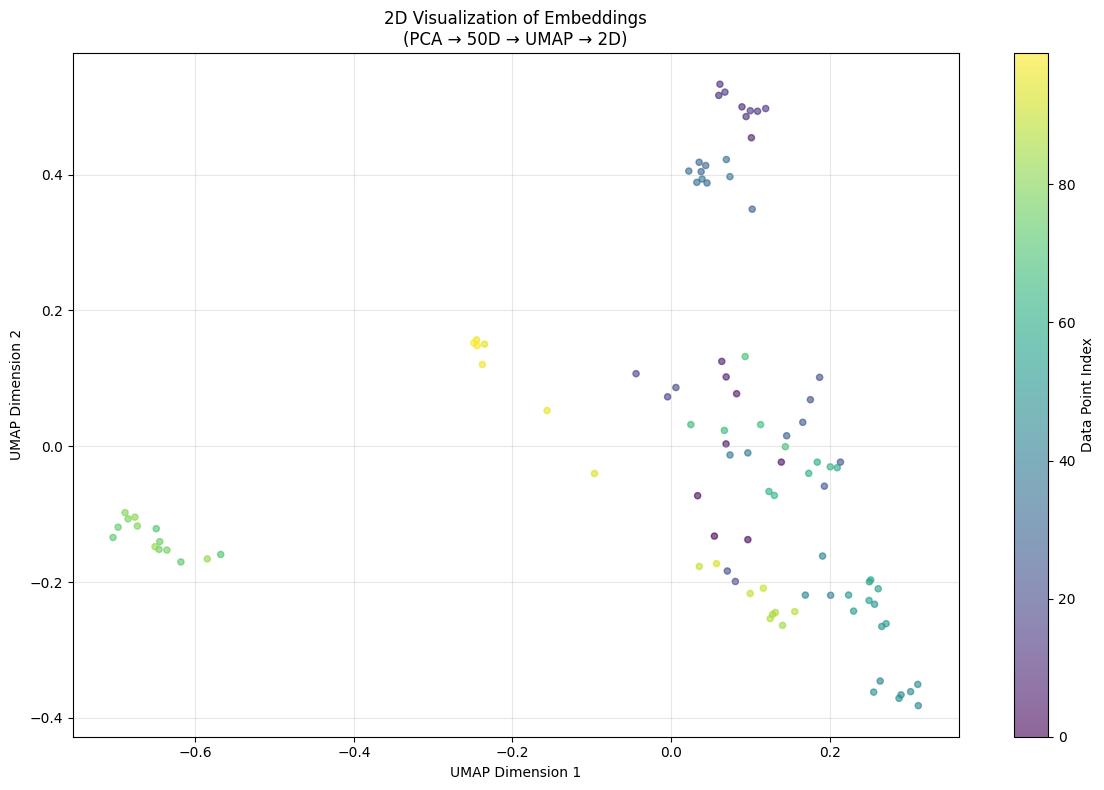

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Extract embeddings from the dataframe (assuming result_df is your dataframe with 'embedding' column)
embeddings_array = np.array(result_df['embedding'].tolist())

print(f"Original embedding shape: {embeddings_array.shape}")

# Step 1: Reduce dimensions to 50 using PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_array[:100])
print(f"After PCA: {embeddings_2d.shape}")
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Step 3: Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     alpha=0.6, s=20, c=range(len(embeddings_2d)), cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D Visualization of Embeddings\n(PCA → 50D → UMAP → 2D)')
plt.colorbar(scatter, label='Data Point Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
def calculate_similar_pairs(embeddings_tensor, threshold=0.8, verbose=True):

    similar_pairs = []

    # Compute cosine similarity matrix
    cos_sim_matrix = util.cos_sim(embeddings_tensor, embeddings_tensor)

    # Get indices of upper triangle (i < j)
    triu_indices = torch.triu_indices(cos_sim_matrix.size(0), cos_sim_matrix.size(1), offset=1)

    # Get similarity scores for upper triangle
    sim_scores = cos_sim_matrix[triu_indices[0], triu_indices[1]]

    # Filter by threshold
    mask = sim_scores > threshold
    i_indices = triu_indices[0][mask].tolist()
    j_indices = triu_indices[1][mask].tolist()
    scores = sim_scores[mask].tolist()

    # Collect similar pairs
    similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
    
    return similar_pairs, scores

def create_embeddings_tensor(duplicates=False):
    result_df_final = result_df.copy()
    if duplicates == False:
        result_df_final = result_df.drop_duplicates(subset=["source description"]).reset_index(drop=True)

    combined_embeddings = result_df_final["embedding"].tolist()
    combined_texts = result_df_final["text_to_compare"].tolist()

    start_time = time.time()
    embeddings_tensor = torch.stack([torch.tensor(e) for e in combined_embeddings])
    return embeddings_tensor, combined_texts, combined_embeddings, result_df_final

def save_duplicates(dup_df):
    duplicates = dup_df[dup_df.duplicated("source description", keep=False)]
    # Drop unwanted columns if they exist
    columns_to_drop = [col for col in ["Source Text", "embedding"] if col in duplicates.columns]
    duplicates = duplicates.drop(columns=columns_to_drop)
    # Save to CSV
    duplicates.to_csv("data/results/duplicates.csv", index=False)
    print(len(duplicates), "was the length of duplicates in total")

    

Last datapoint: 27, 0.9940890051700451


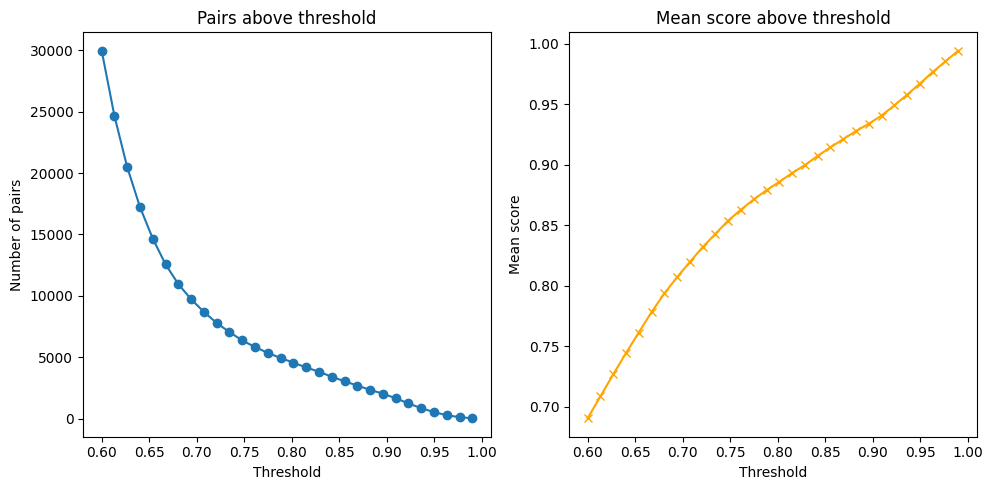

In [7]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
mean_scores = []

embeddings_tensor, combined_texts, combined_embeddings, mutated_result_df = create_embeddings_tensor()

for threshold in thresholds:
    similar_pairs, scores = calculate_similar_pairs(embeddings_tensor, threshold=threshold)
    pair_counts.append(len(similar_pairs))
    mean_scores.append(np.mean(scores) if scores else 0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_scores[-1]}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, pair_counts, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of pairs')
plt.title('Pairs above threshold')

plt.subplot(1, 2, 2)
plt.plot(thresholds, mean_scores, marker='x', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean score')
plt.title('Mean score above threshold')

plt.tight_layout()
plt.show()

# Let's group the pairs

In [8]:
def group_similar_pairs(similar_pairs):
    
    # Create adjacency list representation
    graph = defaultdict(set)
    
    # Build the graph from pairs
    for i, j, score in similar_pairs:
        graph[i].add(j)
        graph[j].add(i)
     
    # Find connected components using DFS
    visited = set()
    groups = []
    
    def dfs(node, current_group):
        if node in visited:
            return
        visited.add(node)
        current_group.add(node)
        
        # Visit all neighbors
        for neighbor in graph[node]:
            dfs(neighbor, current_group)
    
    # Find all connected components
    for node in graph:
        if node not in visited:
            current_group = set()
            dfs(node, current_group)
            if current_group:  # Only add non-empty groups
                groups.append(current_group)
    
    return groups



In [9]:
import random
similar_pairs, scores = calculate_similar_pairs(embeddings_tensor)
groups_sorted = group_similar_pairs(similar_pairs)
# Ensure there are at least 5 groups
num_samples = min(5, len(groups_sorted))
random_groups = random.sample(groups_sorted, num_samples)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")


Sample of 10 random groups:

Group 1 (size: 2):
  Index 1898: STARDUST - STARDUST project that supported Tampere's goal to be a carbon neutral city by 2030 throug...
  Index 2181: STARDUST - STARDUST is a project that supports Tampere's goal of becoming a carbon-neutral city by 2...

Group 2 (size: 4):
  Index 55: Porsche Taycan model with 350 kW charging capacity - An electric car model released by Porsche featu...
  Index 57: charging capacity of Porsche Taycan electric car (350 kW) - The Porsche Taycan electric car model wi...
  Index 230: Porsche Taycan-mallillaan - The Porsche Taycan model, announced in 2019, features 350 kW charging ca...
  Index 231: Porsche Taycan-mallillaan, jota voi ladata 350 kW:n teholla - An electric vehicle model, Porsche Tay...

Group 3 (size: 3):
  Index 1980: FAMOUS ATV concept vehicle - A concept vehicle for arctic mobility demonstrated at Eurosatory 2024 |...
  Index 2432: FAMOUS ATV concept vehicle - A concept vehicle for all-terrain mobility named

Last datapoint: 26, 2.0384615384615383


<Figure size 1000x500 with 0 Axes>

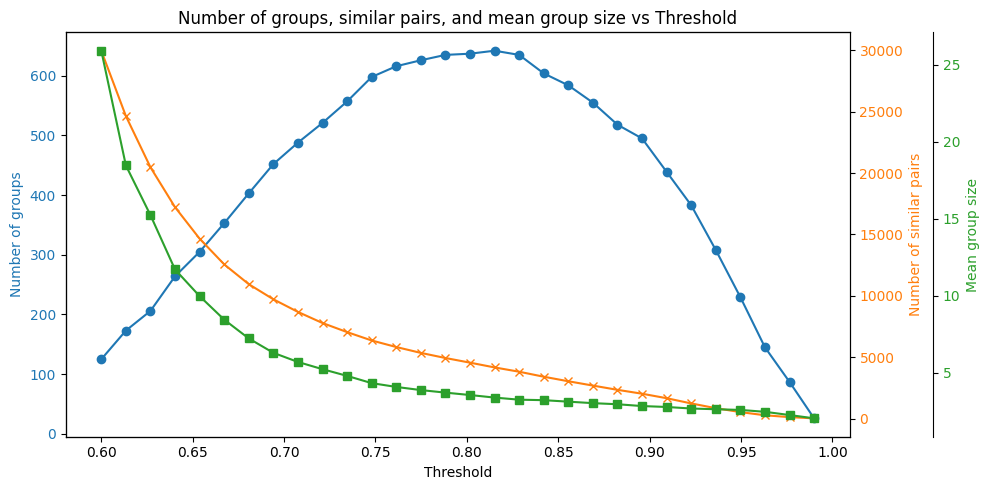

In [10]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
pair_sizes = []
mean_group_sizes = []

for threshold in thresholds:
    
    similar_pairs, scores = calculate_similar_pairs(embeddings_tensor, threshold)
    groups = group_similar_pairs(similar_pairs)
    pair_counts.append(len(groups))
    pair_sizes.append(len(similar_pairs))  # Track number of similar pairs
    if groups:
        mean_group_sizes.append(np.mean([len(g) for g in groups]))
    else:
        mean_group_sizes.append(0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_group_sizes[-1]}")

plt.figure(figsize=(10, 5))
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of groups', color=color)
ax1.plot(thresholds, pair_counts, marker='o', color=color, label='Number of groups')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of similar pairs', color=color)
ax2.plot(thresholds, pair_sizes, marker='x', color=color, label='Number of similar pairs')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Mean group size', color=color)
ax3.plot(thresholds, mean_group_sizes, marker='s', color=color, label='Mean group size')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Number of groups, similar pairs, and mean group size vs Threshold')
fig.tight_layout()
plt.show()

# Let's create the final groups and graph

In [11]:
embeddings_tensor, combined_texts, combined_embeddings, result_df_mutated = create_embeddings_tensor()

In [12]:
similar_pairs_final, scores_final = calculate_similar_pairs(embeddings_tensor, threshold=0.8)
print("original amount of rows", len(result_df))
save_duplicates(result_df)

original amount of rows 6839
4225 was the length of duplicates in total


In [13]:
groups_final = group_similar_pairs(similar_pairs_final)
groups_final_saved = [ list(x) for x in groups_final]
with open("data/results/groups_final.json", "w") as f:
    json.dump(groups_final_saved, f) 


In [14]:
groups_final = None
with open("data/results/groups_final.json", "r") as f:
    groups_final = json.load(f)
    groups_final = [set(x) for x in groups_final]

random_groups = random.sample(groups_final, 5)

print(f"\nSample of 5 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")


Sample of 5 random groups:

Group 1 (size: 3):
  Index 139: Smart Clothing 2.0 wearable technology solution for firefighters - A wearable technology solution de...
  Index 140: Smart Clothing 2.0 Real-time Heat Stress Monitoring Method - A wearable technology solution develope...
  Index 143: Smart Clothing 2.0 -hankekokonaisuudessa kehitetty uusi menetelmä jolla voidaan arvioida lämpökuormi...

Group 2 (size: 2):
  Index 2810: Bittium Tough SDR radios - Software defined radios developed by Bittium designed for secure and resi...
  Index 3196: Bittium Tough SDR radios - Software defined radios developed for tough operational environments enha...

Group 3 (size: 3):
  Index 3445: Prime-korkoaan 0,50 prosenttiin - The reduction of Suomen AsuntoHypoPankki Oy's Prime interest rate ...
  Index 3446: Prime-korkoaan 0,60 prosenttiin - The reduction of Suomen AsuntoHypoPankki Oy's Prime interest rate ...
  Index 3447: Prime-koron lasku 0,10 prosenttiyksikköä 0,30 prosenttiin - Finland AsuntoH

ungrouped points 42


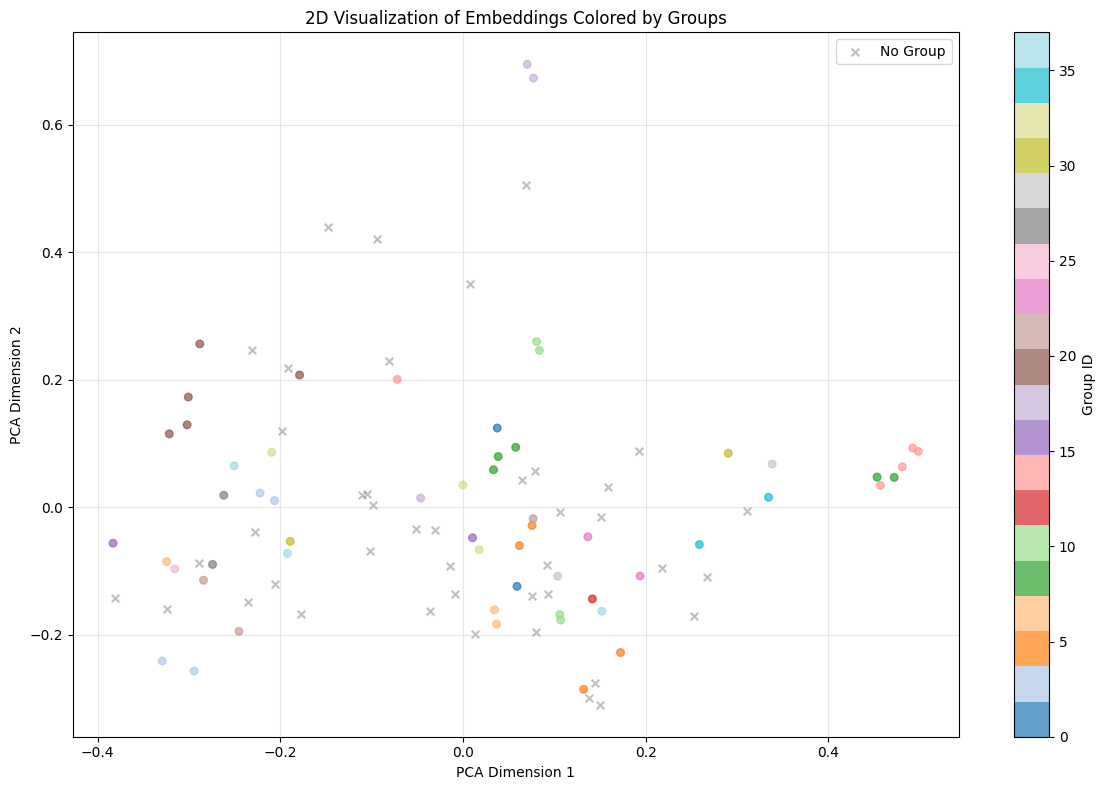

In [15]:
embeddings_mutated = np.array(result_df_mutated["embedding"].to_list())

embeddings_2d = pca.fit_transform(embeddings_mutated[:100])
# Create a mapping from index to group number,
index_to_group = {}
for group_idx, group in enumerate(groups_final):
    for idx in group:
        index_to_group[idx] = group_idx

# Create color array for all points (first 100 in this case),
xy = []
non_grouped = []
for i in range(len(embeddings_2d)):
    if i in index_to_group:
        xy.append((embeddings_2d[i, 0], embeddings_2d[i, 1], index_to_group[i]))
    else:
        non_grouped.append((embeddings_2d[i, 0], embeddings_2d[i, 1], -1))



xy = np.array(xy)
# Create scatter plot colored by groups,
plt.figure(figsize=(12, 8))
scatter = plt.scatter(xy[:, 0], xy[:, 1], 
                     alpha=0.7, s=30, c=xy[:, 2], cmap='tab20')

non_grouped = np.array(non_grouped)

# Handle ungrouped points with different marker,
ungrouped_mask = np.where(non_grouped[:, 2] == -1, True, False)
if ungrouped_mask.any():
   print("ungrouped points", len(non_grouped[ungrouped_mask]))
   plt.scatter(non_grouped[ungrouped_mask, 0], non_grouped[ungrouped_mask, 1], 
              alpha=0.5, s=30, c='gray', marker='x', label='No Group')

plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('2D Visualization of Embeddings Colored by Groups')
plt.colorbar(scatter, label='Group ID')
if ungrouped_mask.any():
    plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Now validate groups

In [16]:
## from pydantic import BaseModel
from typing import List
from langchain_openai import AzureChatOpenAI
import asyncio
from langchain.schema import HumanMessage, SystemMessage
from pydantic import BaseModel


class FalsePositives(BaseModel):
    reasoning: str = ""
    innovations: List[int] = []
    

SYSTEM_PROMPT = """You are an expert innovation analyst. 

You will receive groups of innovations that were identified as potential duplicates based on their embedding vector similarity. By duplicates we mean 
that two or more innovation elements refer to the same innovation, despite having descriptions that slightly differ. 

Your task: Identify which innovation numbers are NOT duplicates in the group but that they are actually different innovations than the others in the group.

Return only the numbers of innovations that represent different projects/technologies, and only do it when you are very confident that they are different."""

def create_user_prompt(group_indices, combined_texts, result_df):
    """Create simple user prompt"""
    
    innovations_text = ""
    for i, idx in enumerate(sorted(group_indices), 1):
        innovation_text = combined_texts[idx]
        innovations_text += f"{i}. {innovation_text}\n\n"

    return f"""Which innovations are NOT duplicates? {innovations_text}Return the numbers of distinct innovations."""

def initialize_llm(deployment_model:str, config_file_path:str= 'data/keys/azure_config.json')->AzureChatOpenAI: 
    with open(config_file_path, 'r') as jsonfile:
        config = json.load(jsonfile)
    
    return AzureChatOpenAI(model =deployment_model,
                    api_key=config[deployment_model]['api_key'],
                    azure_endpoint = config[deployment_model]['api_base'],
                    api_version = config[deployment_model]['api_version'])

# Initialize with structured output
llm = initialize_llm(deployment_model="gpt-4.1-mini").with_structured_output(FalsePositives)

async def evaluate_group(group, combined_texts, result_df):
    
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=create_user_prompt(group, combined_texts, result_df))
    ]
    
    result = await llm.ainvoke(messages)

    return {
        "group_indices": list(group),
        "false_positives": result.innovations,
        "reasoning": result.reasoning
    }
    
# Process all groups
async def evaluate_all_groups(groups, combined_texts, result_df):
    i = 0
    tasks = []
    for i, group in enumerate(groups):
        if len(group) >= 2:
            tasks.append(evaluate_group(group, combined_texts, result_df))
    results = await asyncio.gather(*tasks)
    return results

In [17]:
results = await evaluate_all_groups(groups_final, combined_texts, result_df)
      
with open("./data/results/results_with_reasoning.json", "w") as f:
    json.dump(results, f, indent=2)
   

In [18]:
groups_final_final = []
final_results = None

with open("./data/results/results_with_reasoning.json", "r") as f:
    final_results = json.load(f)
# [0, 2017, 1574, 1575, 1225, 3403, 3404, 1517, 942, 943, 816, 2645]

nondup_results_df = result_df.drop_duplicates(subset=["source description"]).reset_index(drop=True)


for res in final_results:
    members = res["group_indices"]
    to_exclude = res["false_positives"]
    diff = list(set(members) - set(to_exclude))
    groups_final_final.append(diff)

group_final_ids = groups_final_final
groups_final_final = [[nondup_results_df.iloc[idx] for idx in y] for y in groups_final_final]

groups_json = [
    [
        {k: v for k, v in row.to_dict().items() if k not in ["embedding", "Source Text"]}
        for row in group
    ]
    for group in groups_final_final
]

with open("data/results/enhanced_groups.json", "w") as f:
    json.dump(groups_json, f, indent=2)


In [ ]:

class Summarization(BaseModel):
    title: str = ""
    description: str = ""

SYSTEM_PROMPT_SUMMARIZATION = """You are an expert innovation analyst. 

You will receive a list of innovations that have been identified as duplicates. 

Your task: Summarize the innovations in the group into a title and a description.

The title should be a short title for the innovation group, and the description should be a short description of the innovation itself based on description of innovations.
Do not lose any information that is relevant to the innovation.
"""


enhanced_groups = None
with open("./data/results/enhanced_groups.json", "r") as f:
    enhanced_groups = json.load(f)

# Let's go through the groups and summarize them
llm_for_summarization = initialize_llm(deployment_model="gpt-4.1-mini").with_structured_output(Summarization)
# Generate prompts
user_prompts = {}
for idx, e_group in enumerate(enhanced_groups):
    prompt_lines = []
    for i, innovation in enumerate(e_group):
        prompt_lines.append(f"{i+1}. {innovation['source english_id']}: {innovation['source description']}. {innovation['relationship description']}")
    user_prompts[idx] = "\n".join(prompt_lines)

# Create and run parallel LLM tasks
tasks = [
    llm_for_summarization.ainvoke([
        SystemMessage(content=SYSTEM_PROMPT_SUMMARIZATION),
        HumanMessage(content=user_prompt)
    ])
    for user_prompt in user_prompts.values()
]

results = await asyncio.gather(*tasks)

# Map results to group IDs
summarized_by_group_id = {group_id: result for group_id, result in zip(user_prompts.keys(), results)}

In [ ]:
def get_all_organizations_for_innovation_group(group_indices, innovations_dedup, df_combined, df_combined_no_filter):
    """Get all organizations involved with an innovation group from the full dataset"""
    
    # Get all innovation names in this group
    innovation_names = []
    for idx in group_indices:
        innovation_names.append(innovations_dedup.iloc[idx]['source english_id'])
        
    # Get document numbers where these innovations appear as source OR target
    innovation_docs_as_source = df_combined_no_filter[
        df_combined_no_filter['source english_id'].isin(innovation_names)
    ]['Document number'].unique()
    
    innovation_docs_as_target = df_combined_no_filter[
        df_combined_no_filter['target english_id'].isin(innovation_names)
    ]['Document number'].unique()
    
    innovation_docs = list(set(list(innovation_docs_as_source) + list(innovation_docs_as_target)))
    
    all_relationships = df_combined_no_filter[
        df_combined_no_filter['Document number'].isin(innovation_docs)
    ]
    
    organizations = {}
    
    for _, row in all_relationships.iterrows():
        # Handle DEVELOPED_BY relationships (Innovation -> Organization)
        if row['relationship type'] == 'DEVELOPED_BY':
            target_id = row['target id']
            target_name = row['target english_id']
            
            if target_id not in organizations:
                organizations[target_id] = {
                    'name': target_name,
                    'developed_by': False,
                    'collaboration': False,
                    'mentions': []
                }
            
            organizations[target_id]['developed_by'] = True
            organizations[target_id]['mentions'].append({
                'innovation_name': row['source english_id'],
                'relationship_type': 'DEVELOPED_BY',
                'document_number': row['Document number']
            })
        
        # Handle COLLABORATION relationships (Organization -> Organization)
        elif row['relationship type'] == 'COLLABORATION':
            
            # Add both source and target organizations as collaborators
            for org_id, org_name in [(row['source id'], row['source english_id']), 
                                   (row['target id'], row['target english_id'])]:
                
                if org_id not in organizations:
                    organizations[org_id] = {
                        'name': org_name,
                        'developed_by': False,
                        'collaboration': False,
                        'mentions': []
                    }
                
                organizations[org_id]['collaboration'] = True
                organizations[org_id]['mentions'].append({
                    'innovation_context': f"Document {row['Document number']} - Collaboration between organizations",
                    'relationship_type': 'COLLABORATION',
                    'document_number': row['Document number'],
                    'collaboration_partner': row['target english_id'] if org_id == row['source id'] else row['source english_id']
                })
    
    return organizations

def create_unified_innovations(innovation_groups, innovations_dedup, df_combined, df_combined_no_filter):
    """Create final unified innovation records"""
    
    unified_innovations = []
    
    for group_idx, group in enumerate(innovation_groups):
        if len(group) == 1:  # Single innovation, not a duplicate group
            continue
            
        # Get canonical innovation (longest description)
        group_list = list(group)
        canonical_idx = max(group_list, 
                          key=lambda x: len(innovations_dedup.iloc[x]['source description'] or ''))
        canonical = innovations_dedup.iloc[canonical_idx]

        
        
        # Get all organizations involved with this innovation group
        organizations = get_all_organizations_for_innovation_group(group, innovations_dedup, df_combined, df_combined_no_filter)

        vtt_org = organizations.get('FI26473754', {})
        vtt_roles = []
        if vtt_org.get('developed_by', False):
            vtt_roles.append('developer')
        if vtt_org.get('collaboration', False):
            vtt_roles.append('collaborator')


        # Separate developers and collaborators
        developers = [org for org_id, org in organizations.items() if org['developed_by']]
        collaborators = [org for org_id, org in organizations.items() if org['collaboration']]
        
        # FIXED: Determine VTT's role(s) properly
        vtt_org = organizations.get('FI26473754', {})
        vtt_roles = []
        if vtt_org.get('developed_by', False):
            vtt_roles.append('developer')
        if vtt_org.get('collaboration', False):
            vtt_roles.append('collaborator')

        result = summarized_by_group_id[group_idx]
        
        unified = {
            'group_id': f"innovation_group_{group_idx}",
            'canonical_name': result.title,
            'canonical_description': result.description,
            'aliases': [innovations_dedup.iloc[idx]['source english_id'] for idx in group],
            'total_mentions': len(group),
            'developers': developers,
            'collaborators': collaborators,
            'vtt_role': '+'.join(vtt_roles) if vtt_roles else 'unknown',
            'document_numbers': list(set([mention['document_number'] for org in organizations.values() for mention in org['mentions']])),
        }
        
        unified_innovations.append(unified)
    
    return unified_innovations

# Create the final unified innovations
unified_innovations = create_unified_innovations(group_final_ids, nondup_results_df, df_combined, pd.read_csv("data/results/df_combined.no_filter.csv"))


print(f"Created {len(unified_innovations)} unified innovation records")
import json

def fix_nan(obj):
    if isinstance(obj, dict):
        return {k: fix_nan(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [fix_nan(item) for item in obj]
    elif pd.isna(obj):
        return None
    else:
        return obj

# Clean and save
cleaned_innovations = fix_nan(unified_innovations)

# Save results
with open('data/results/unified_innovations_5.json', 'w') as f:
    json.dump(cleaned_innovations, f, indent=2)

# Display sample results
print("\nSample Unified Innovations:")
for innovation in unified_innovations[:3]:
    print(f"\n{'='*60}")
    print(f"Innovation: {innovation['canonical_name']}")
    print(f"Description: {innovation['canonical_description']}")
    print(f"Aliases: {innovation['aliases']}")
    print(f"VTT Role: {innovation['vtt_role']}")
    print(f"Developers: {[dev['name'] for dev in innovation['developers']]}")
    print(f"Collaborators: {[collab['name'] for collab in innovation['collaborators']]}")
    print(f"Total mentions: {innovation['total_mentions']}")


final_df = pd.DataFrame(unified_innovations)
final_df.to_csv('data/results/vtt_unified_innovations.csv', index=False)
print(f"\nSaved {len(final_df)} unified innovations to CSV")